#NEURAL NETWORKS AND DEEP LEARNING
# Homework 1
---
Elena Leonelli - mat.2028635 - M.Sc. Physics of data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms

from sklearn.model_selection import KFold, ParameterGrid, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [ ]:
! pip install skorch
import skorch
from skorch import NeuralNetClassifier, NeuralNetRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 6.6 MB/s 


# Regression task

The goal is to train a neural network to approximate an unknown function
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$


The training set consists in noisy measures from the target function:
$
\hat{y} = f(x) + noise.
$

In this section, I start defining a fully-connected neural network. Then I perform a preliminary training and testing.
In section "Grid Search" I sdefine a function that performs a randomized search with crossvalidation. With this function I find the best parameters, and I train again the network to obtain the best performance. The final test loss reached is 0.1.

Eventually, I analyze the network plotting activation profiles and weight histograms.

## Dataset

The following cell of code will download the dataset. Each row contains two values, respactively the input and the label.

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-07-08 12:53:17--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-07-08 12:53:18 (49.6 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-07-08 12:53:18--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [ ]:
#LOADING DATA

train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

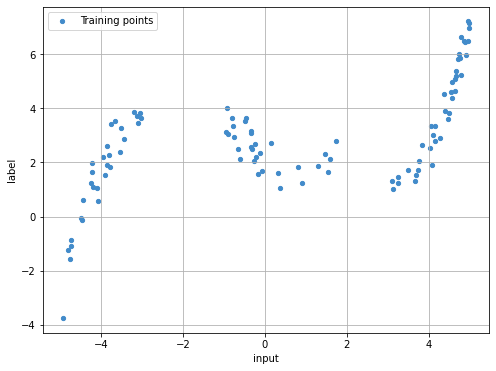

In [ ]:
#TRAINING POINTS VISUALIZATION

fig = plt.figure(figsize=(8,6))
plt.scatter(train_df.input, train_df.label,s=18, label='Training points', color='#428bca')
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()

### Datasets loading: from csv to Tensor

In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Creating a tuple (input,label)
        self.transform = transform
        data_df=pd.read_csv(csv_file)

        self.data=[tuple(r) for r in data_df.to_numpy()]
        
    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    # Convert sample to Tensors

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

## The Model

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Nh1, Nh2, activ, p_drop=0, Ni=1, No=1):

        super().__init__()

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = activ
        self.dropout = nn.Dropout(p_drop)
        
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [ ]:
# Initialize the network
torch.manual_seed(60)

Nh1 = 64
Nh2 = 128

net = Net(Nh1, Nh2, nn.ReLU())
net.to(device)

Net(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0, inplace=False)
)

## Training

In [ ]:
# Divide in training (80%) an validation (20%) dataset

p = 0.8
n_train = int(len(train_dataset)*p) 
n_valid = len(train_dataset) - n_train

print("Elements in Train set:",      n_train)
print("Elements in Validation set:", n_valid)
print("Elements in Test set:",       len(test_dataset) )

# Prepare Training and Validation sets
train_dataset_v, validation_dataset_v = torch.utils.data.random_split(train_dataset, [n_train, n_valid])

Elements in Train set: 80
Elements in Validation set: 20
Elements in Test set: 100


In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset_v, batch_size=10, shuffle=True)
### Define validation dataloader
validation_dataloader = DataLoader(validation_dataset_v, batch_size=10, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(validation_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([10, 1])
	 Labels: torch.Size([10, 1])
TRAIN BATCH SHAPE
	 Data: torch.Size([10, 1])
	 Labels: torch.Size([10, 1])
TEST BATCH SHAPE
	 Data: torch.Size([10, 1])
	 Labels: torch.Size([10, 1])


In [ ]:
def training(parameters, Net=Net, device=device, best_pars=False, classification=False,
             train_dataloader=train_dataloader, validation_dataloader=validation_dataloader):

  # Initialize the network
  torch.manual_seed(60)

  net = Net(parameters['nh1'], parameters['nh2'], parameters['activation'], parameters['dropout'])
  net.to(device)

  # Loss and optimizer
  loss_fn = parameters['loss_fn']

  # Define the optimizer
  if parameters['optimizer'] == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr=parameters['lr'], weight_decay=parameters['wd'])
  elif parameters['optimizer'] == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=parameters['lr'], weight_decay=parameters['wd'])
  elif parameters['optimizer'] == 'RMS':
    optimizer = optim.RMSprop(net.parameters(), lr=parameters['lr'], weight_decay=parameters['wd'])
  else: print('Something went wrong..')


  ### TRAINING LOOP
  train_loss_log = [] 
  val_loss_log = []

  for epoch_num in tqdm(range(parameters['num_epochs'])):
    ### TRAIN
    train_loss = []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)

    for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)
      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()
      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average (over batches) train loss for each epoch
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in validation_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    if (epoch_num+1)%200 == 0:
      print(f'# EPOCH {epoch_num+1}',f"AVERAGE TRAIN LOSS: {train_loss:.2f}",f"AVERAGE VAL LOSS: {np.mean(val_loss):.2f}")


  ###SAVE WEIGHTS
  if best_pars:
    torch.save(net,'net_best.pt') 
  elif classification:
    torch.save(net,'net_class.pt') 


  return train_loss_log, val_loss_log


In [ ]:
parameters = {
    'num_epochs': 1000,
    'activation': nn.ReLU(),
    'dropout': 0.,
    'nh1': 64,
    'nh2': 128,
    'loss_fn': nn.MSELoss(),
    'optimizer': 'Adam',
    'lr': 1e-3,
    'wd': 0
    }


In [ ]:
training_loss, validation_loss = training(parameters)

 21%|██        | 211/1000 [00:03<00:12, 65.05it/s]

# EPOCH 200 AVERAGE TRAIN LOSS: 0.27 AVERAGE VAL LOSS: 0.28


 41%|████      | 407/1000 [00:06<00:09, 63.97it/s]

# EPOCH 400 AVERAGE TRAIN LOSS: 0.25 AVERAGE VAL LOSS: 0.32


 61%|██████    | 610/1000 [00:09<00:06, 64.76it/s]

# EPOCH 600 AVERAGE TRAIN LOSS: 0.24 AVERAGE VAL LOSS: 0.30


 81%|████████  | 806/1000 [00:12<00:02, 64.93it/s]

# EPOCH 800 AVERAGE TRAIN LOSS: 0.26 AVERAGE VAL LOSS: 0.42


100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


# EPOCH 1000 AVERAGE TRAIN LOSS: 0.21 AVERAGE VAL LOSS: 0.26


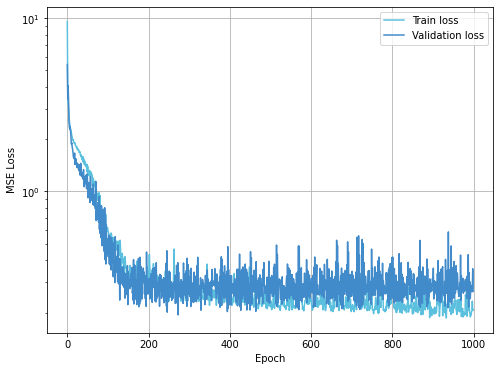

In [ ]:
# Plot losses
fig = plt.figure(figsize=(8,6))
plt.semilogy(training_loss, label='Train loss', color = '#5bc0de')
plt.semilogy(validation_loss, label='Validation loss', color = '#428bca')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

## Test

In [ ]:
# Input vector
x_vec = torch.linspace(-5,5,5000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")


net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")


# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()


Input shape: torch.Size([5000, 1])
Output shape: torch.Size([5000, 1])


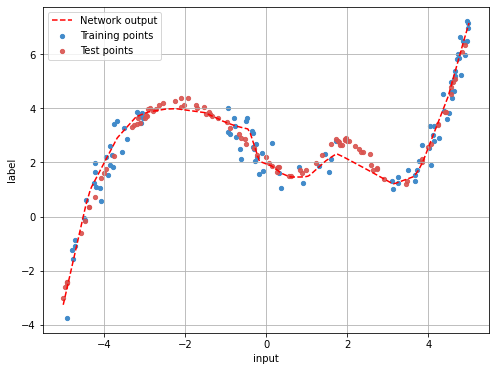

In [ ]:
# Plot output

fig = plt.figure(figsize=(8,6))
plt.plot(x_vec, y_vec, '--', color='red', label='Network output')
plt.scatter(train_df.input, train_df.label, s=18, label='Training points', color='#428bca')
plt.scatter(test_df.input, test_df.label, s=18, label='Test points', color='#d9534f', alpha=0.9)
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()


## Grid Search


In [ ]:
def random_gs_cv(p_dict,train_dataset,n_sampling,seed,early_stop=50):


  #SELEZIONO IL DICT CON CUI LAVORO
  random.seed(seed)

  param_grid = ParameterGrid(p_dict)
  selected = random.sample(list(param_grid),n_sampling)

  results = []

  for dict_ in tqdm(selected):

    # Initialize the network
    torch.manual_seed(60)

    net = Net(dict_['nh1'], dict_['nh2'], dict_['activation'], dict_['dropout'])
    net.to(device)

    # Define the loss function
    loss_fn = dict_['loss_fn']


    # Define the optimizer
    if dict_['optimizer'] == 'Adam':
      optimizer = optim.Adam(net.parameters(), lr=dict_['lr'], weight_decay=dict_['wd'])
    elif dict_['optimizer'] == 'SGD':
      optimizer = optim.SGD(net.parameters(), lr=dict_['lr'], weight_decay=dict_['wd'])
    elif dict_['optimizer'] == 'RMS':
      optimizer = optim.RMSprop(net.parameters(), lr=dict_['lr'], weight_decay=dict_['wd'])
    else: print('Something went wrong..')

    #crossvalidation
    splits = KFold(n_splits=dict_['fold'],shuffle=True,random_state=376)

    batch_size = dict_['batch']
    num_epochs = dict_['num_epochs']

    train_loss_fold = 0
    val_loss_fold = 0

    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

      train_sampler = SubsetRandomSampler(train_idx)
      val_sampler = SubsetRandomSampler(val_idx)
      train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
      val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

      ### TRAINING LOOP

      train_loss_log = [] #for each fold, they will contain the average (over batch) train loss, one for each epoch
      val_loss_log = []
      
      train_loss = [] #contengono le loss dell'ultima epoch per tutte le batch
      val_loss = []

      for epoch_num in range(num_epochs):
        ### TRAIN
        
        net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)

        for sample_batched in train_dataloader:
          # Move data to device
          x_batch = sample_batched[0].to(device)
          label_batch = sample_batched[1].to(device)

          # Forward pass
          out = net(x_batch)

          # Compute loss
          loss = loss_fn(out, label_batch)

          # Backpropagation
          net.zero_grad() #cleaning gradients
          loss.backward()

          # Update the weights
          optimizer.step()

          # Save train loss for this batch only for the last epoch
          if epoch_num+1 == num_epochs:
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)


        ### VALIDATION
        net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
        with torch.no_grad(): # Disable gradient tracking
          for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save train loss for this batch only for the last epoch
            if epoch_num+1 == num_epochs:
              loss_batch = loss.detach().cpu().numpy()
              val_loss.append(loss_batch)

      # Save average train and validation loss for final epoch per ogni fold
      train_loss = np.mean(train_loss)
      train_loss_log.append(train_loss)

      val_loss = np.mean(val_loss)
      val_loss_log.append(val_loss)

      if epoch_num > early_stop and (all(x > val_loss for x in val_loss_log[-early_stop:])):
        print('Early stopping occurs')
        break

      ### RESET WEIGHTS
      for layer in net.children():
        if hasattr(layer, 'reset_parameters'): #The hasattr() function returns True if the specified object has the specified attribute, otherwise False.
          layer.reset_parameters()


    #appendo solo i valori dell'ultima epoch mediati su tutte le fold
    train_loss_fold = np.mean(train_loss_log)
    val_loss_fold = np.mean(val_loss_log)
    
    #aggiungo solo il valore medio di tutte le fold
    dict_['train_loss'] = train_loss_fold #media sulle batch e poi sulle fold
    dict_['val_loss'] = val_loss_fold

    #risultati
    results.append(dict_)

  return results
          

In [ ]:
params = {
    'fold' : [5],
    'num_epochs' : [200],
    'nh1' : [64,128],
    'nh2' : [16,64],
    'activation' : [nn.ReLU(),nn.Sigmoid()],
    'dropout' : [0,0.2,0.4],
    'batch' : [10],
    'optimizer' : ['SGD','Adam','RMS'],
    'lr' : [0.05,0.01,0.005,0.001],
    'wd' : [0,0.01,0.0001],
    'loss_fn': [nn.MSELoss()]
}


In [ ]:
ris = random_gs_cv (params,train_dataset,n_sampling=20,seed=456)


100%|██████████| 20/20 [03:13<00:00,  9.66s/it]


In [ ]:
ris_df=pd.DataFrame.from_dict(ris).sort_values(by=['train_loss'])
ris_df.head()


,activation,batch,dropout,fold,loss_fn,lr,nh1,nh2,num_epochs,optimizer,wd,train_loss,val_loss
18,ReLU(),10,0.0,5,MSELoss(),0.005,64,64,200,Adam,0.0001,0.283996,0.372161
12,Sigmoid(),10,0.0,5,MSELoss(),0.005,128,64,200,Adam,0.0000,0.298850,0.307902
7,ReLU(),10,0.0,5,MSELoss(),0.010,64,16,200,Adam,0.0001,0.380157,0.377968
15,Sigmoid(),10,0.0,5,MSELoss(),0.010,128,64,200,Adam,0.0001,0.399696,0.374514
13,ReLU(),10,0.0,5,MSELoss(),0.001,64,64,200,RMS,0.0100,0.513080,0.345560


## Training with the best params found

In [ ]:
best_params = {
    'num_epochs': 2000,
    'activation': nn.ReLU(),
    'dropout': 0,
    'nh1': 64,
    'nh2': 64,
    'loss_fn': nn.MSELoss(),
    'optimizer': 'Adam',
    'lr': 0.005,
    'wd': 0.0001
}

In [ ]:
best_training_loss, best_validation_loss = training(best_params, best_pars=True)

 11%|█         | 215/2000 [00:03<00:20, 85.47it/s]

# EPOCH 200 AVERAGE TRAIN LOSS: 0.41 AVERAGE VAL LOSS: 0.57


 21%|██        | 413/2000 [00:05<00:19, 83.22it/s]

# EPOCH 400 AVERAGE TRAIN LOSS: 0.29 AVERAGE VAL LOSS: 0.29


 31%|███       | 611/2000 [00:08<00:16, 84.44it/s]

# EPOCH 600 AVERAGE TRAIN LOSS: 0.29 AVERAGE VAL LOSS: 0.36


 41%|████      | 811/2000 [00:10<00:15, 78.92it/s]

# EPOCH 800 AVERAGE TRAIN LOSS: 0.22 AVERAGE VAL LOSS: 0.34


 50%|█████     | 1007/2000 [00:14<00:22, 44.02it/s]

# EPOCH 1000 AVERAGE TRAIN LOSS: 0.21 AVERAGE VAL LOSS: 0.31


 60%|██████    | 1210/2000 [00:17<00:09, 81.36it/s]

# EPOCH 1200 AVERAGE TRAIN LOSS: 0.32 AVERAGE VAL LOSS: 0.41


 71%|███████   | 1414/2000 [00:20<00:07, 81.98it/s]

# EPOCH 1400 AVERAGE TRAIN LOSS: 0.31 AVERAGE VAL LOSS: 0.31


 81%|████████  | 1612/2000 [00:22<00:05, 76.23it/s]

# EPOCH 1600 AVERAGE TRAIN LOSS: 0.25 AVERAGE VAL LOSS: 0.30


 91%|█████████ | 1813/2000 [00:25<00:02, 79.04it/s]

# EPOCH 1800 AVERAGE TRAIN LOSS: 0.21 AVERAGE VAL LOSS: 0.34


100%|██████████| 2000/2000 [00:28<00:00, 70.01it/s]

# EPOCH 2000 AVERAGE TRAIN LOSS: 0.25 AVERAGE VAL LOSS: 0.38


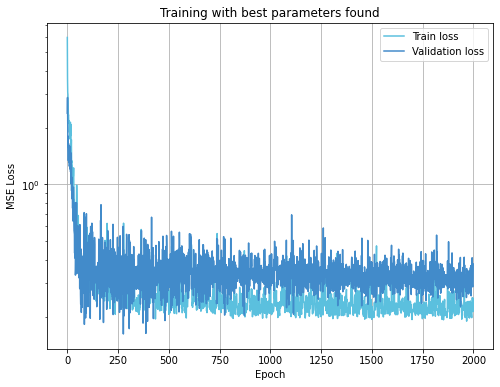

In [ ]:
# Plot losses
fig = plt.figure(figsize=(8,6))
plt.semilogy(best_training_loss, label='Train loss', color = '#5bc0de')
plt.semilogy(best_validation_loss, label='Validation loss', color = '#428bca')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training with best parameters found')
plt.grid()
plt.legend()
plt.show()

In [ ]:
net = torch.load('net_best.pt')

# Input vector
x_vec = torch.linspace(-5,5,5000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector


net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()



In [ ]:
#TEST LOSS
loss_fn = nn.MSELoss()
test_loss = []

net.eval()
with torch.no_grad():
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)
    # Save val loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    test_loss.append(loss_batch)


test_loss = np.mean(test_loss)


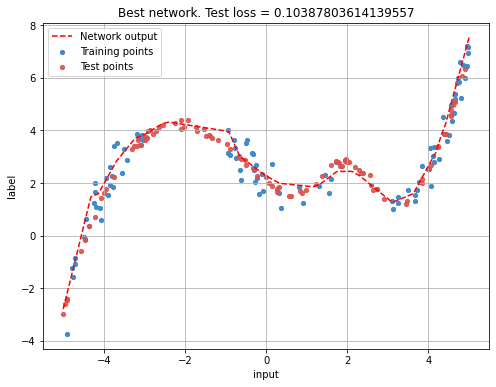

In [ ]:
# Plot output

fig = plt.figure(figsize=(8,6))
plt.plot(x_vec, y_vec, '--', color='red', label='Network output')
plt.scatter(train_df.input, train_df.label, s=18, label='Training points', color='#428bca')
plt.scatter(test_df.input, test_df.label, s=18, label='Test points', color='#d9534f', alpha=0.9)
plt.xlabel('input')
plt.ylabel('label')
plt.title(f'Best network. Test loss = {test_loss}')
plt.grid()
plt.legend()
plt.show()


## Weight histograms



In [ ]:
net = torch.load('net_best.pt')

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

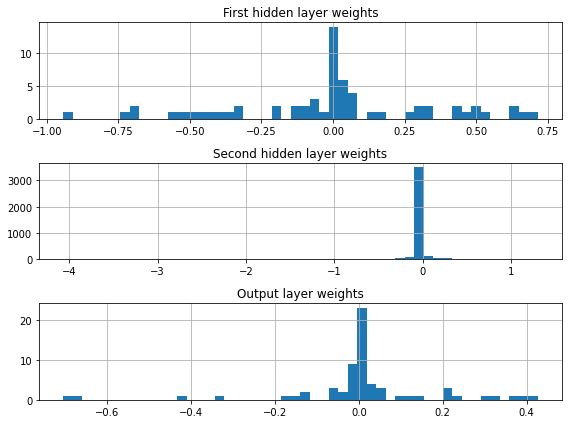

In [ ]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(8,6))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Activation profiles

In [ ]:
net = torch.load('net_best.pt')

In [ ]:
def get_activ(layer, input, output):
    global activ
    activ = torch.relu(output)

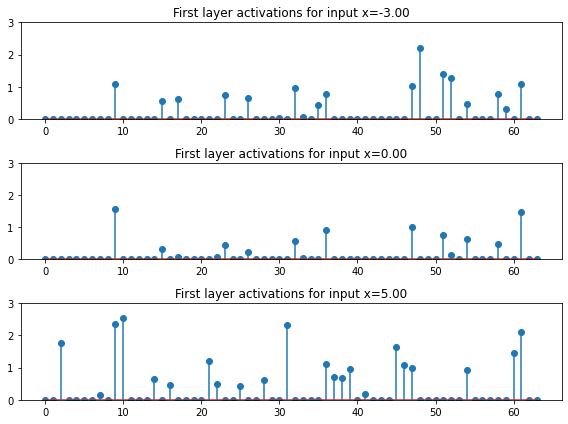

In [ ]:
### Register hook  
hook_handle = net.fc1.register_forward_hook(get_activ)

### Analyze activations

net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-3]).float().to(device)
    y1 = net(x1)
    z1 = activ
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2 = activ
    x3 = torch.tensor([5]).float().to(device)
    y3 = net(x3)
    z3 = activ

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(8,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1)
axs[0].set_ylim(0,3)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('First layer activations for input x=%.2f' % x2)
axs[1].set_ylim(0,3)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('First layer activations for input x=%.2f' % x3)
axs[2].set_ylim(0,3)
plt.tight_layout()
plt.show()

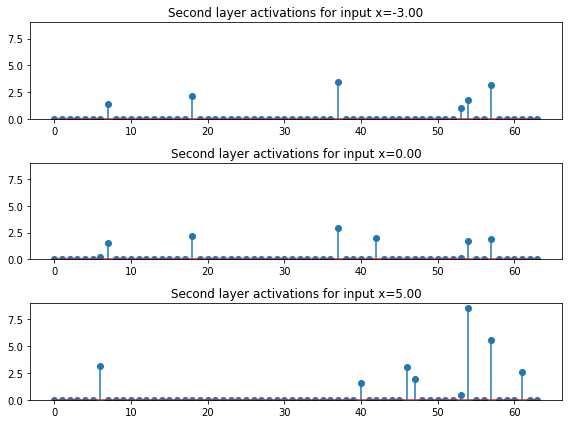

In [ ]:
### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activ)

### Analyze activations

net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-3]).float().to(device)
    y1 = net(x1)
    z1 = activ
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2 = activ
    x3 = torch.tensor([5]).float().to(device)
    y3 = net(x3)
    z3 = activ

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(8,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Second layer activations for input x=%.2f' % x1)
axs[0].set_ylim(0,9)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=%.2f' % x2)
axs[1].set_ylim(0,9)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Second layer activations for input x=%.2f' % x3)
axs[2].set_ylim(0,9)
plt.tight_layout()
plt.show()

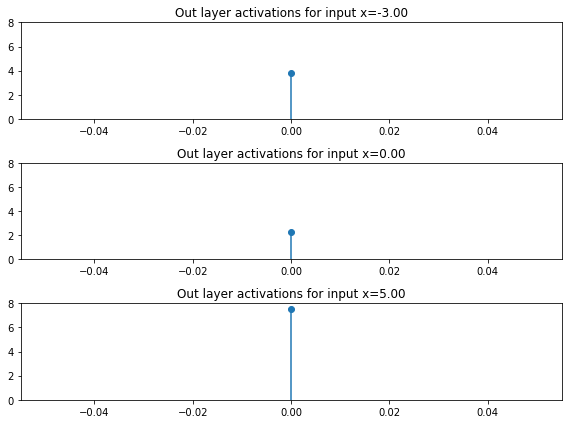

In [ ]:
### Register hook  
hook_handle = net.out.register_forward_hook(get_activ)

### Analyze activations

net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-3]).float().to(device)
    y1 = net(x1)
    z1 = activ
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2 = activ
    x3 = torch.tensor([5]).float().to(device)
    y3 = net(x3)
    z3 = activ

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(8,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Out layer activations for input x=%.2f' % x1)
axs[0].set_ylim(0,8)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Out layer activations for input x=%.2f' % x2)
axs[1].set_ylim(0,8)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Out layer activations for input x=%.2f' % x3)
axs[2].set_ylim(0,8)
plt.tight_layout()
plt.show()

In these activation profiles is clearly shown the difference between the inputs: their label are significantly different, and this is well represented in the network activity.

# Classification task

The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).

In this section I start by performing classification with a fully connected neural network (the 'vanilla' classification). After this, I define a CNN and, using Skorch, perform a randomized grid search with crossvalidation.

Finally, I analyze the network plotting weights and activation profiles.

## Dataset

Download the dataset:

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=0.5,std=0.5)
                              ])

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True,transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [ ]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

## 'Vanilla' classification (FFNN)

In [ ]:
# Divide in training (80%) an validation (20%) dataset

p = 0.8
n_train = int(len(train_dataset)*p) 
n_valid = len(train_dataset) - n_train

print("Elements in Train set:",      n_train)
print("Elements in Validation set:", n_valid)
print("Elements in Test set:",       len(test_dataset) )

# Prepare Training and Validation sets
train_dataset_v, validation_dataset_v = torch.utils.data.random_split(train_dataset, [n_train, n_valid])

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000


In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset_v, batch_size=256, shuffle=True)
### Define validation dataloader
validation_dataloader = DataLoader(validation_dataset_v, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(validation_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([100, 1, 28, 28])
	 Labels: torch.Size([100])


In [ ]:
class NetClass(nn.Module):
    
    def __init__(self, Nh1, Nh2, activ, p_drop=0, Ni=784, No=10):

        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1, bias=True)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2, bias=True)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = activ
        self.dropout = nn.Dropout(p_drop)
        
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
parameters = {
    'num_epochs': 20,
    'activation': nn.ReLU(),
    'dropout': 0.,
    'nh1': 256,
    'nh2': 128,
    'loss_fn': nn.CrossEntropyLoss(),
    'optimizer': 'Adam',
    'lr': 1e-3,
    'wd': 0.01
    }


In [ ]:
#TRAINING with the same function as before
training_loss, validation_loss = training(parameters,Net=NetClass, classification=True,
                                          train_dataloader=train_dataloader,
                                          validation_dataloader=validation_dataloader)

Network initialized


100%|██████████| 20/20 [04:34<00:00, 13.74s/it]


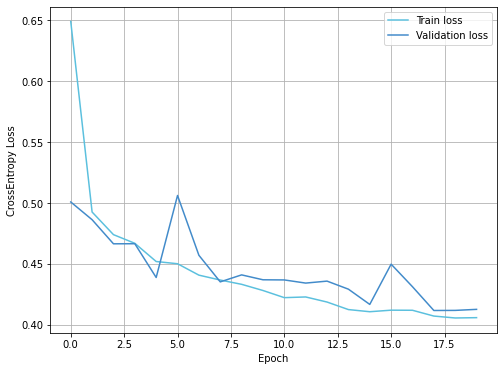

In [ ]:
# Plot losses
fig = plt.figure(figsize=(8,6))
plt.plot(training_loss, label='Train loss', color = '#5bc0de')
plt.plot(validation_loss, label='Validation loss', color = '#428bca')

plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.grid()
plt.legend()
plt.show()

### Test

In [ ]:
net_class = torch.load('net_class.pt')
net_class

NetClass(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
def test(model):
    criterion = nn.CrossEntropyLoss()
    batch_size=100
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.to(device)

    model.eval()
    
    for images,labels in test_dataloader:
        images,labels=images.to(device),labels.to(device)
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_dataloader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {fashion_class[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (fashion_class[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    

In [ ]:
test(net_class)

For NetClass :
Test Loss: 0.4375082874298096
Correctly predicted per class : [763.0, 936.0, 830.0, 908.0, 695.0, 951.0, 614.0, 859.0, 947.0, 922.0], Total correctly perdicted : 8425.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class T-shirt/top : 76.3% where 763 of 1000 were predicted correctly
Test Accuracy of class Trouser : 93.6% where 936 of 1000 were predicted correctly
Test Accuracy of class Pullover : 83.0% where 830 of 1000 were predicted correctly
Test Accuracy of class Dress : 90.8% where 908 of 1000 were predicted correctly
Test Accuracy of class Coat : 69.5% where 695 of 1000 were predicted correctly
Test Accuracy of class Sandal : 95.1% where 951 of 1000 were predicted correctly
Test Accuracy of class Shirt : 61.4% where 614 of 1000 were predicted correctly
Test Accuracy of class Sneaker : 85.9% where 859 of 1000 were predicted correctly
Test Accura

## CNN

Here I use SKORCH for training, parameters optimization, and testing.

In [ ]:
train_dataset_x = train_dataset.data.type(torch.float32).reshape(60000,1,28,28)
train_dataset_label = train_dataset.targets.type(torch.int64).reshape(60000)
test_dataset_x  = test_dataset.data.type(torch.float32).reshape(10000,1,28,28)
test_dataset_label  = test_dataset.targets.type(torch.int64).reshape(10000)

In [ ]:
class Net_conv(nn.Module):
  def __init__(self, Nh1=256, Nh2=128, p_drop=0.2, activ=nn.ReLU(), No=10):

    super(Net_conv,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

    self.fc1=nn.Linear(7*7*32,Nh1)
    self.fc2=nn.Linear(Nh1,Nh2)
    self.out=nn.Linear(Nh2,No)
    self.act=activ
    self.dropout=nn.Dropout(p_drop)

  def forward(self,x):
    x=self.act(self.pool(self.conv1(x)))
    x=self.act(self.pool(self.dropout(self.conv2(x))))
    x=x.view(-1,7*7*32)
    x=self.dropout(x)
    x=self.act(self.dropout(self.fc1(x)))
    x=self.act(self.fc2(x))
    x=torch.softmax(self.out(x), dim=-1)
    return x

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [ ]:

torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Net_conv,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device
)



In [ ]:
cnn.fit(train_dataset_x,train_dataset_label)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7013       0.8478        0.4164  27.2932
      2        0.4074       0.8760        0.3372  27.4344
      3        0.3678       0.8798        0.3183  28.7898
      4        0.3410       0.8863        0.3024  28.4577
      5        0.3235       0.8981        0.2822  28.6191
      6        0.3070       0.8984        0.2800  29.5158
      7        0.2901       0.9008        0.2754  28.2263
      8        0.2839       0.9070        0.2647  28.6578
      9        0.2678       0.9073        0.2622  27.9216
     10        0.2713       0.8978        0.2847  27.8817


In [ ]:
y_pred_cnn = cnn.predict(test_dataset_x)

In [ ]:
#Accuracy test set
accuracy_score(test_dataset_label, y_pred_cnn)

0.8934

### Randomized Grid Search

In [ ]:

params = {
    'lr': [0.01, 0.005, 0.001],
    'batch_size': [128,256],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'optimizer__weight_decay': [0.05,0.01,0.005],
    'module__p_drop': [0,0.2,0.4,0.6],
    'module__Nh1': [64,128],
    'module__Nh2': [64,128]
    }


cnn = NeuralNetClassifier(module = Net_conv,
                          module__p_drop = 0.4,
                          module__Nh1 = 128,
                          module__Nh2 = 64,
                          max_epochs = 10,
                          batch_size = 128,
                          lr = 0.002,
                          optimizer = torch.optim.Adam,
                          optimizer__weight_decay = 0.01,
                          device = device,
                          iterator_train__shuffle = True,
)



In [ ]:
gs = RandomizedSearchCV(cnn, params, refit=False, cv=3, scoring='accuracy', n_iter=10)

gs.fit(train_dataset_x, train_dataset_label)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1       13.9121       0.1000       14.3481  18.1319
      2       13.8702       0.1000       14.3481  16.6389
      3       10.9809       0.1000       14.3481  15.8800
      4       10.0230       0.1000       14.3481  16.7152
      5       10.0204       0.1000       14.3481  17.3737
      6       10.0095       0.1000       14.3481  25.6314
      7        7.4808       0.4536        1.4404  18.0969
      8        1.2326       0.6428        1.1374  16.5413
      9        1.1089       0.6710        0.9913  16.8487
     10        1.0672       0.6884        0.9591  16.5773
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5394       0.6920        0.9691  16.2252
      2        0.9691       0.7569        0.8145  16.7010
      3        0.8585       0.7406        0.7192  16.0435
      4       

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net_conv'>,
  module__Nh1=128,
  module__Nh2=64,
  module__p_drop=0.4,
),
                   param_distributions={'batch_size': [128, 256],
                                        'lr': [0.01, 0.005, 0.001],
                                        'module__Nh1': [64, 128],
                                        'module__Nh2': [64, 128],
                                        'module__p_drop': [0, 0.2, 0.4, 0.6],
                                        'optimizer': [<class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.rmsprop.RMSprop'>],
                                        'optimizer__weight_decay': [0.05, 0.01,
                                                                    0.005]},
               

In [ ]:
gs.best_params_

{'batch_size': 128,
 'lr': 0.01,
 'module__Nh1': 64,
 'module__Nh2': 128,
 'module__p_drop': 0,
 'optimizer': torch.optim.sgd.SGD,
 'optimizer__weight_decay': 0.005}

### Training best parameters

In [ ]:
cnn_best = NeuralNetClassifier(batch_size = 128,
                               lr = 0.01,
                               module__Nh1 = 64,
                               module__Nh2 = 128,
                               module__p_drop = 0,
                               optimizer = torch.optim.SGD,
                               optimizer__weight_decay = 0.005,
                               module = Net_conv,
                               max_epochs = 30,
                               device = device,
                               iterator_train__shuffle = True,
)

Now I re-train with those parameters, and test

In [ ]:
cnn_best.fit(train_dataset_x,train_dataset_label)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.5784       0.8213        0.4754  25.3166
      2        0.3594       0.8778        0.3428  24.4743
      3        0.3148       0.8845        0.3175  23.9981
      4        0.2851       0.8971        0.2867  24.5397
      5        0.2692       0.8904        0.3023  23.9007
      6        0.2539       0.9022        0.2718  23.8772
      7        0.2392       0.8960        0.2757  25.9512
      8        0.2310       0.9054        0.2583  24.2884
      9        0.2197       0.9061        0.2605  23.6943
     10        0.2131       0.9085        0.2515  25.7526
     11        0.2061       0.9049        0.2610  24.3108
     12        0.1979       0.9033        0.2652  23.1802
     13        0.1920       0.8975        0.2770  23.1564
     14        0.1841       0.9117        0.2433  22.9847
     15        0.1788       0.9172        0.2379  23.0982
     16       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net_conv(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1568, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=10, bias=True)
    (act): ReLU()
    (dropout): Dropout(p=0, inplace=False)
  ),
)

### Test



In [ ]:
y_pred_cnn = cnn_best.predict(test_dataset_x)

In [ ]:
accuracy_score(test_dataset_label, y_pred_cnn)

0.9049

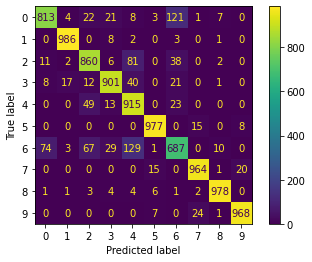

In [ ]:

cm = confusion_matrix(test_dataset_label, y_pred_cnn)

ConfusionMatrixDisplay(cm).plot()
plt.show()

## Weights

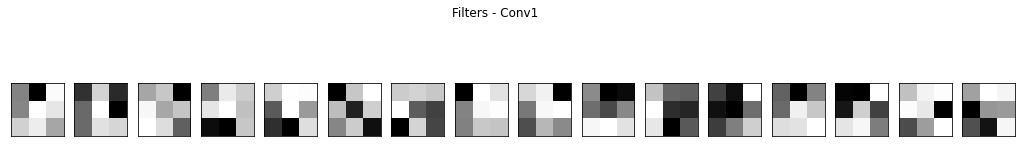

In [ ]:
# First hidden layer
conv1_w = cnn_best.module_.conv1.weight.data.cpu().numpy()
conv2_w = cnn_best.module_.conv2.weight.data.cpu().numpy()

fig, ax = plt.subplots(1,16, figsize=(18, 3))

for i in range(16):
    ax[i].imshow(conv1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters - Conv1 ', fontsize = 12)
plt.show()

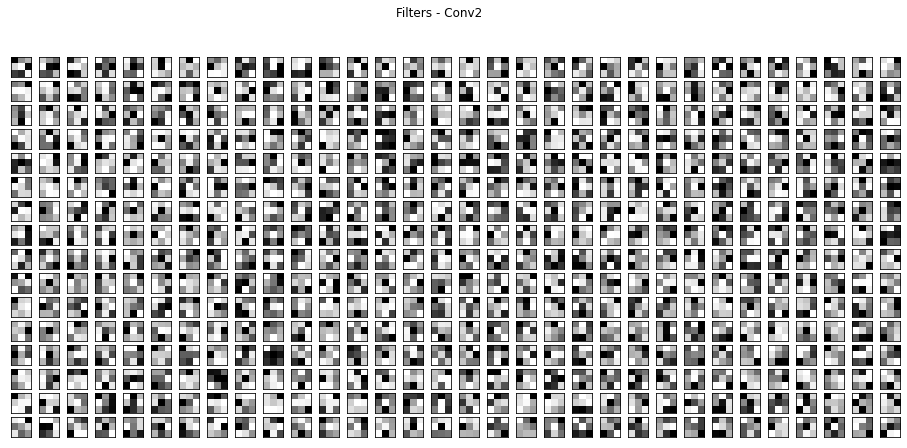

In [ ]:
fig, ax = plt.subplots(16, 32, figsize=(16, 7))

for i in range(16):
    for j in range(32):
        ax[i,j].imshow( conv2_w[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig.suptitle('Filters - Conv2 ', fontsize = 12)
plt.savefig('filters_CL1_2.png')
plt.show()

In [ ]:
# First convolutional layer
c1_w = cnn_best.module_.conv1.weight.data.cpu().numpy()
c1_b = cnn_best.module_.conv1.bias.data.cpu().numpy()

# Second convolutional layer
c2_w = cnn_best.module_.conv2.weight.data.cpu().numpy()
c2_b = cnn_best.module_.conv2.bias.data.cpu().numpy()

# First hidden layer
h1_w = cnn_best.module_.fc1.weight.data.cpu().numpy()
h1_b = cnn_best.module_.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = cnn_best.module_.fc2.weight.data.cpu().numpy()
h2_b = cnn_best.module_.fc2.bias.data.cpu().numpy()

# Output layer
out_w = cnn_best.module_.out.weight.data.cpu().numpy()
out_b = cnn_best.module_.out.bias.data.cpu().numpy()

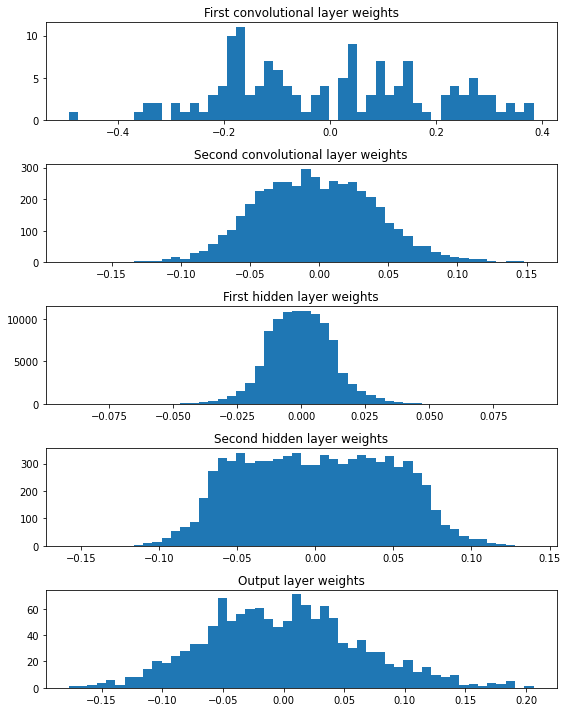

In [ ]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(8,10))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First convolutional layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Second convolutional layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First hidden layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second hidden layer weights')
axs[4].hist(out_w.flatten(), 50)
axs[4].set_title('Output layer weights')

plt.tight_layout()
plt.show()

## Activation profiles



In [ ]:
activation = {}
def getActivation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

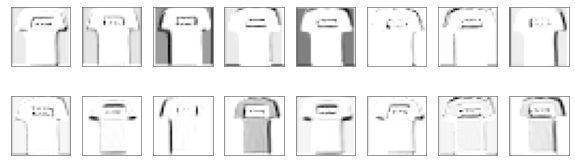

In [ ]:
conv1 = cnn_best.module_.conv1.register_forward_hook(getActivation('conv1'))

x = train_dataset[1][0].cpu().unsqueeze(0).to(device)
layers = [cnn_best.module_.conv1, nn.ReLU()]

for layer in layers:
    x = layer(x)
    
out_conv1 = x.squeeze(0).cpu().detach().numpy()

fig, ax = plt.subplots(2,8, figsize=(10, 3))
j=0
for a, filt in enumerate(out_conv1):
    if a<8:
        ax[0][a].grid(False)
        ax[0][a].imshow(filt, cmap='Greys')
        ax[0][a].set_xticks([])
        ax[0][a].set_yticks([])
        ax[0][a].spines['bottom'].set_color('0.5')
        ax[0][a].spines['top'].set_color('0.5')
        ax[0][a].spines['right'].set_color('0.5')
        ax[0][a].spines['left'].set_color('0.5')
    else: 
        ax[1][a-8].grid(False)
        ax[1][a-8].imshow(filt, cmap='Greys')
        ax[1][a-8].set_xticks([])
        ax[1][a-8].set_yticks([])
        ax[1][a-8].spines['bottom'].set_color('0.5')
        ax[1][a-8].spines['top'].set_color('0.5')
        ax[1][a-8].spines['right'].set_color('0.5')
        ax[1][a-8].spines['left'].set_color('0.5')

conv1.remove()